In [1]:
# !pip install regdata
import torch
import matplotlib.pyplot as plt
import pyro
import pyro.contrib.gp as gp
from gpytorch.kernels import RBFKernel, ScaleKernel
from skgpytorch.models import ExactGPRegressor
import regdata
from time import time

In [2]:
def plot():
    with torch.no_grad():
        plt.plot(x_train, y_train, 'o', label='Training data')
        plt.plot(x_test.numpy(), pred_mean.numpy(), label='predictive mean')
        plt.fill_between(x_test.ravel(), pred_mean - 2 * (pred_var**0.5), pred_mean + 2 * (pred_var**0.5), alpha=0.5, label='2 standard deviations')
        plt.legend();

In [3]:
n_iters = 50

x_train, y_train, x_test = regdata.SineNoisy(backend='torch', samples=400).get_data()
x_train.shape, y_train.shape, x_test.shape

(torch.Size([400, 1]), torch.Size([400]), torch.Size([800, 1]))

### Fitting vanilla GP model

In [4]:
kernel = gp.kernels.RBF(input_dim=1, variance=torch.tensor(2.0), lengthscale=torch.tensor(0.5))
gp_model = gp.models.GPRegression(x_train, y_train, kernel=kernel, noise=torch.tensor(0.1))
type(gp_model), isinstance(gp_model, torch.nn.Module)

(pyro.contrib.gp.models.gpr.GPRegression, True)

In [5]:
for name, value in gp_model.named_parameters():
    print(name, "{:.2f}".format(value.item()))

noise_unconstrained -2.30
kernel.variance_unconstrained 0.69
kernel.lengthscale_unconstrained -0.69


In [6]:
init = time()
gp.util.train(gp_model, num_steps=n_iters)
time()-init

5.841933965682983

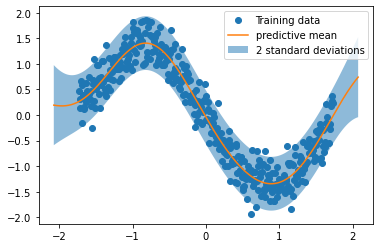

In [7]:
pred_mean, pred_var = gp_model(x_test, noiseless=False)
plot()

### Fitting a variational GP model

In [8]:
kernel = gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.0), lengthscale=torch.tensor(1.0))
vgp_model = gp.models.VariationalGP(x_train, y_train, kernel=kernel, likelihood=gp.likelihoods.Gaussian())
type(vgp_model), isinstance(vgp_model, torch.nn.Module)

(pyro.contrib.gp.models.vgp.VariationalGP, True)

In [9]:
for name, value in vgp_model.named_parameters():
    print(name, value.shape)

f_loc torch.Size([400])
f_scale_tril_unconstrained torch.Size([400, 400])
kernel.variance_unconstrained torch.Size([])
kernel.lengthscale_unconstrained torch.Size([])
likelihood.variance_unconstrained torch.Size([])


In [10]:
init = time()
gp.util.train(vgp_model, num_steps=n_iters, optimizer=torch.optim.Adam(vgp_model.parameters(), lr=0.1));
time() - init

1.193211317062378

(-1.5, 1.5)

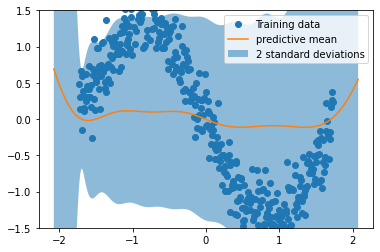

In [11]:
pred_mean, pred_var = vgp_model(x_test)
# pred_mean.shape, pred_var.shape
plot()
plt.ylim([-1.5, 1.5])

### Fitting GPyTorch model

In [12]:
kernel = ScaleKernel(RBFKernel())
gpytorch_model = ExactGPRegressor(x_train, y_train, kernel=kernel)

In [13]:
for name, value in gpytorch_model.named_parameters():
    print(name, value.shape)

mll.likelihood.noise_covar.raw_noise torch.Size([1])
mll.model.mean_module.constant torch.Size([1])
mll.model.covar_module.raw_outputscale torch.Size([])
mll.model.covar_module.base_kernel.raw_lengthscale torch.Size([1, 1])


In [14]:
init = time()
gpytorch_model.fit(n_epochs=n_iters)
time()-init

0.4716145992279053

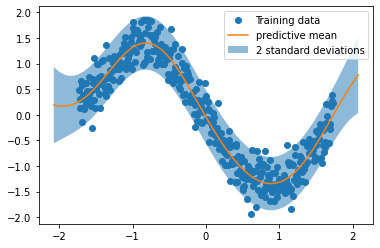

In [15]:
pred_dist = gpytorch_model.predict(x_test)
pred_mean, pred_var = pred_dist.mean, pred_dist.variance
plot()